In [ ]:
#!pip install pycaret

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re
from pycaret.classification import setup,compare_models,create_model, tune_model, evaluate_model, predict_model, finalize_model, save_model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
import os

In [ ]:
os.chdir( "/content/drive/My Drive/PES_MTech_inperson/S3_S4")

### Load the dataset from the disk

In [ ]:
import pandas as pd
df = pd.read_csv('complaints.csv') # We are taking less rows for faster execution
df.head()

,Consumer complaint narrative,Product
0,I have outdated information on my credit repor...,Credit reporting
1,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
2,An account on my credit report has a mistaken ...,Credit reporting
3,This company refuses to provide me verificatio...,Debt collection
4,This complaint is in regards to Square Two Fin...,Debt collection


In [ ]:
df.shape

(179776, 2)

In [ ]:
df['Product'].value_counts()

,count
Product,
Debt collection,43946
Mortgage,34576
Credit reporting,31589
Credit card,18845
Bank account or service,14892
Student loan,12047
Consumer Loan,9486
"Credit reporting, credit repair services, or other personal consumer reports",6118
Payday loan,1750


<Axes: xlabel='Product'>

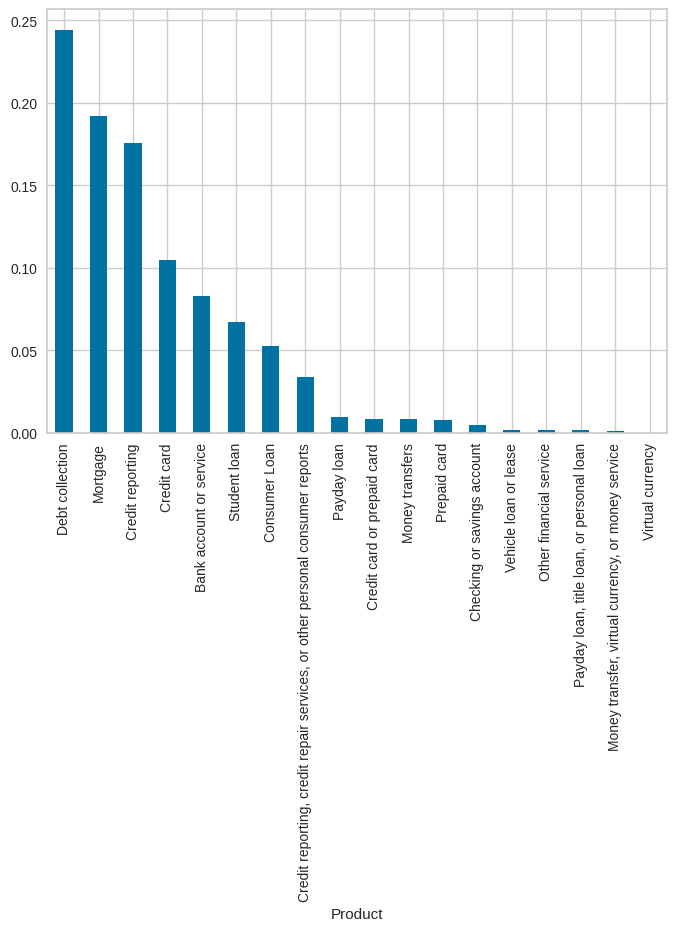

In [ ]:
df['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
stratify_column = 'Product'

In [ ]:
df_prod, _=train_test_split(df, test_size=0.75, stratify=df[stratify_column], random_state=42)

In [ ]:
df.shape

(179776, 2)

In [ ]:
df_prod.shape

(44944, 2)

<Axes: xlabel='Product'>

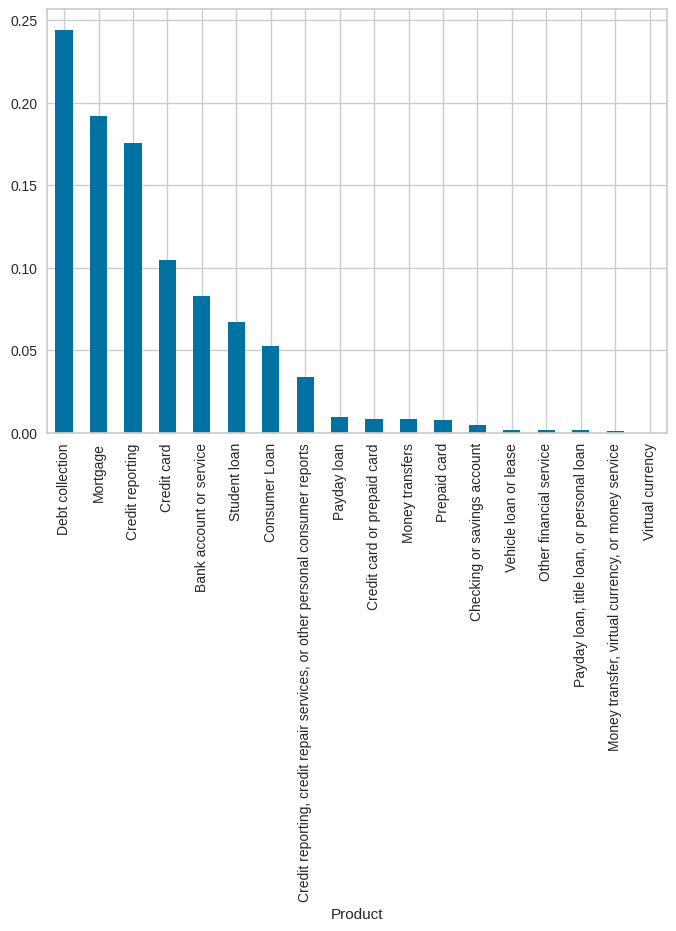

In [ ]:
df_prod['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
threshold=0.05

In [ ]:
values_below_threshold = df_prod['Product'].value_counts(normalize=True)
values_below_threshold = values_below_threshold[df_prod['Product'].value_counts(normalize=True) <=threshold ].index.tolist()

In [ ]:
values_below_threshold

['Credit reporting, credit repair services, or other personal consumer reports',
 'Payday loan',
 'Credit card or prepaid card',
 'Money transfers',
 'Prepaid card',
 'Checking or savings account',
 'Vehicle loan or lease',
 'Other financial service',
 'Payday loan, title loan, or personal loan',
 'Money transfer, virtual currency, or money service',
 'Virtual currency']

In [ ]:
len(values_below_threshold)

11

In [ ]:
df_prod['Product'] = df_prod['Product'].apply(lambda x: 'Other' if x in values_below_threshold else x)

<Axes: xlabel='Product'>

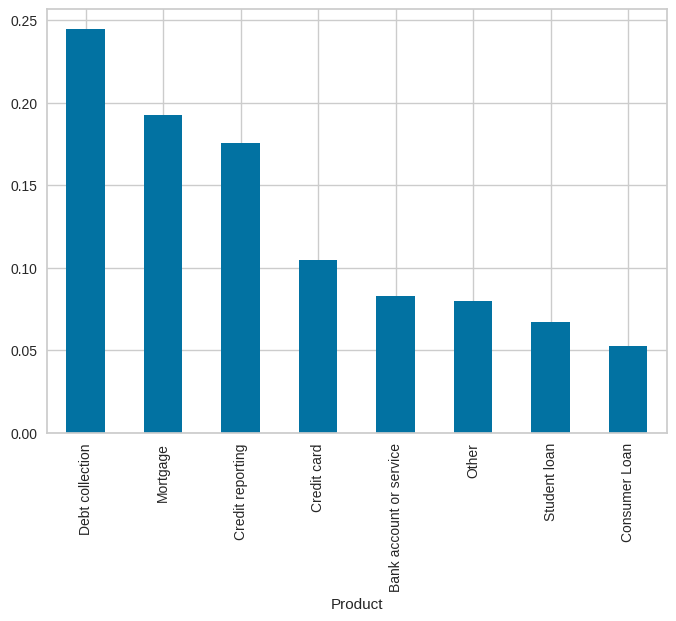

In [ ]:
df_prod['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
df_prod.isnull().sum()

,0
Consumer complaint narrative,0
Product,0


### Tokenizer
Regular expression based tokenizers to consider only alphabetical sequences and ignore numerical sequences.

In [ ]:
def cleanup(text):

    #words = comp.lower().split()
    alphabets_only = re.sub("[^a-zA-Z\s]", "", text) # Remove non-alphabetic characters
    alphabets_only = re.sub("\d+", "", alphabets_only)  # Remove digits explicitly
    alphabets_only = re.sub("\s+", " ", alphabets_only).strip() # Remove extra spaces
    return alphabets_only.lower()

In [ ]:
df_prod['Consumer complaint narrative']=df_prod['Consumer complaint narrative'].apply(cleanup)

### Vocabulary
Extracing all the unique words from the dataset

In [ ]:
def complaint_to_words(text) -> list:
    return text.split()

In [ ]:
all_words = list()
for comp in df_prod['Consumer complaint narrative']:
    for w in complaint_to_words(comp):
        all_words.append(w)

In [ ]:
print('Size of vocabulary: {}'.format(len(set(all_words))))

Size of vocabulary: 47743


In [ ]:
print('Complaint\n', df_prod['Consumer complaint narrative'].iloc[10], '\n')
print('Tokens\n', complaint_to_words(df_prod['Consumer complaint narrative'].iloc[10]))

Complaint
 my credit has been in consumer affairs department with equifax since they claim they protecting my identity but this not only effecting me but it is effecting my family i cant purchase a home because there are accounts on my credit from identity theft i have proof of the accounts previous being deleted also it is effecting me with irs because they have businesses reporting income that i have no clue who they are from and it is spilling over from my credit to irs 

Tokens
 ['my', 'credit', 'has', 'been', 'in', 'consumer', 'affairs', 'department', 'with', 'equifax', 'since', 'they', 'claim', 'they', 'protecting', 'my', 'identity', 'but', 'this', 'not', 'only', 'effecting', 'me', 'but', 'it', 'is', 'effecting', 'my', 'family', 'i', 'cant', 'purchase', 'a', 'home', 'because', 'there', 'are', 'accounts', 'on', 'my', 'credit', 'from', 'identity', 'theft', 'i', 'have', 'proof', 'of', 'the', 'accounts', 'previous', 'being', 'deleted', 'also', 'it', 'is', 'effecting', 'me', 'with', '

Conventional ML models with TF_IDF vectorization

In [ ]:
df_prod.sample(10)

,Consumer complaint narrative,Product
98171,i did not authorize xxxx xxxx to run my credit...,Other
3901,i am being charged interest from a month inter...,Credit card
170404,equifax has reported that a xxxx credit card a...,Other
43493,i have xxxx accounts that are over xxxx years ...,Credit reporting
72999,we had a small balance with a chase card that ...,Credit card
113303,my xxxx issue with target started on xxxxxxxxx...,Credit card
3633,you have me living in indiana i have never liv...,Credit reporting
173001,i had xxxx xxxx and i nsurance companies they ...,Debt collection
127845,nationsar mortgage is not acting in good faith...,Mortgage
59571,this company continues to report on my credit ...,Debt collection


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Transform the 'text' column into TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(df_prod['Consumer complaint narrative'])

# Create a DataFrame from the TF-IDF vectors
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

# Add the 'Product' column to the new DataFrame
tfidf_df['Product'] = df_prod['Product'].values

In [ ]:
tfidf_df.sample(10)

,ability,able,about,above,accept,accepted,access,according,account,accounts,...,wrote,xxxx,xxxxxxxx,xxxxxxxxxxxx,year,years,yet,you,your,Product
15031,0.0,0.0,0.045213,0.0,0.0,0.0,0.0,0.000000,0.135823,0.058870,...,0.000000,0.171612,0.092628,0.073603,0.000000,0.149857,0.000000,0.139926,0.00000,Bank account or service
42167,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.081011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,Credit card
16816,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.179623,0.000000,...,0.000000,0.028369,0.000000,0.000000,0.000000,0.000000,0.057011,0.000000,0.02563,Bank account or service
38476,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.069140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,Credit reporting
2113,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.160665,0.000000,...,0.000000,0.101499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,Bank account or service
41874,0.0,0.0,0.053179,0.0,0.0,0.0,0.0,0.091618,0.000000,0.069242,...,0.000000,0.126155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,Credit reporting
22192,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.327903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,Credit reporting
39205,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.059269,0.000000,...,0.000000,0.561648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,Bank account or service
1121,0.0,0.0,0.023062,0.0,0.0,0.0,0.0,0.039732,0.000000,0.000000,...,0.044266,0.000000,0.118118,0.000000,0.059166,0.050959,0.032983,0.000000,0.00000,Mortgage
34011,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.102042,0.073437,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,Debt collection


In [ ]:
df_train=tfidf_df.sample(frac=0.9,random_state=50)
df_test=tfidf_df.drop(df_train.index)

In [ ]:
py_clas=setup(data=df_train,target='Product',  train_size=0.8,session_id=50)

,Description,Value
0,Session id,50
1,Target,Product
2,Target type,Multiclass
3,Target mapping,"Bank account or service: 0, Consumer Loan: 1, Credit card: 2, Credit reporting: 3, Debt collection: 4, Mortgage: 5, Other: 6, Student loan: 7"
4,Original data shape,"(40450, 1001)"
5,Transformed data shape,"(40450, 1001)"
6,Transformed train set shape,"(32360, 1001)"
7,Transformed test set shape,"(8090, 1001)"
8,Numeric features,1000
9,Preprocess,True


In [ ]:
best_model= compare_models(verbose=True,   fold=5, round=3, turbo=True, exclude=['nb','lda', 'qda','dt'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.788,0.958,0.788,0.774,0.777,0.746,0.747,194.070
xgboost,Extreme Gradient Boosting,0.785,0.957,0.785,0.772,0.773,0.743,0.744,195.428
lr,Logistic Regression,0.779,0.000,0.779,0.762,0.764,0.734,0.736,12.006
svm,SVM - Linear Kernel,0.777,0.000,0.777,0.758,0.749,0.732,0.735,4.768
ridge,Ridge Classifier,0.771,0.000,0.771,0.758,0.748,0.724,0.727,1.864
et,Extra Trees Classifier,0.770,0.948,0.770,0.779,0.743,0.722,0.727,42.306
rf,Random Forest Classifier,0.768,0.948,0.768,0.773,0.744,0.721,0.724,29.872
gbc,Gradient Boosting Classifier,0.766,0.000,0.766,0.752,0.752,0.719,0.721,822.132
ada,Ada Boost Classifier,0.701,0.000,0.701,0.675,0.681,0.641,0.644,21.328
knn,K Neighbors Classifier,0.661,0.878,0.661,0.661,0.655,0.597,0.599,20.326


Processing:   0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
py_clf=create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7815,0.0000,0.7815,0.7649,0.7669,0.7375,0.7392
1,0.7695,0.0000,0.7695,0.7504,0.7542,0.7233,0.7250
2,0.7794,0.0000,0.7794,0.7608,0.7650,0.7349,0.7365
3,0.7735,0.0000,0.7735,0.7566,0.7587,0.7279,0.7296
4,0.7852,0.0000,0.7852,0.7703,0.7715,0.7422,0.7439
5,0.7790,0.0000,0.7790,0.7623,0.7654,0.7345,0.7362
6,0.7790,0.0000,0.7790,0.7630,0.7644,0.7346,0.7363
7,0.7794,0.0000,0.7794,0.7619,0.7659,0.7354,0.7368
8,0.7828,0.0000,0.7828,0.7666,0.7683,0.7391,0.7408


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_clf=tune_model(py_clf, round=3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.782,0.000,0.782,0.766,0.767,0.738,0.740
1,0.769,0.000,0.769,0.750,0.754,0.723,0.724
2,0.779,0.000,0.779,0.760,0.764,0.734,0.736
3,0.775,0.000,0.775,0.759,0.761,0.730,0.732
4,0.785,0.000,0.785,0.770,0.771,0.742,0.744
5,0.780,0.000,0.780,0.764,0.767,0.736,0.738
6,0.779,0.000,0.779,0.763,0.764,0.735,0.736
7,0.780,0.000,0.780,0.762,0.767,0.736,0.738
8,0.782,0.000,0.782,0.766,0.768,0.738,0.740


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
evaluate_model(tuned_clf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…